In [1]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras import initializers, regularizers, optimizers
import tensorflow as tf


from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

In [3]:
# To download files
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1fi4HjggYj06qYt40GP9AbI2sSEUIkPyP' -O 'x_ts_L60_Z12_A500_DX50_bias5_N10000.csv'
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1FcaX9VT9PY6WWRWUU5kA4pnKQUPtS9bb' -O 'y_ts_L60_Z12_A500_DX50_bias5_N10000.csv'

--2020-04-11 10:22:21--  https://docs.google.com/uc?export=download&id=1fi4HjggYj06qYt40GP9AbI2sSEUIkPyP
Resolving docs.google.com (docs.google.com)... 172.217.21.78, 2a00:1450:4002:803::200e
Connecting to docs.google.com (docs.google.com)|172.217.21.78|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9jcsqaaumkhrfo35q4ae0jll74hi4fk6/1586593275000/10483148750674350960/*/1fi4HjggYj06qYt40GP9AbI2sSEUIkPyP?e=download [following]
--2020-04-11 10:22:23--  https://doc-04-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9jcsqaaumkhrfo35q4ae0jll74hi4fk6/1586593275000/10483148750674350960/*/1fi4HjggYj06qYt40GP9AbI2sSEUIkPyP?e=download
Resolving doc-04-6k-docs.googleusercontent.com (doc-04-6k-docs.googleusercontent.com)... 216.58.198.1, 2a00:1450:4002:801::2001
Connecting to doc-04-6k-docs.googleusercontent.com (doc-04-6k-docs.googleuse

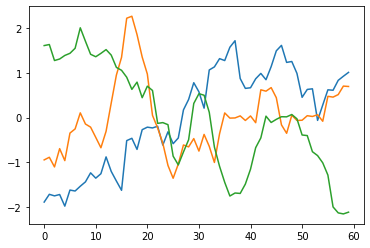

N_train = 8000   N_val =  2000   L=  60  N_class= 3


In [4]:
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.csv'
fnamex = 'x_'+str0
fnamey = 'y_'+str0

x = np.loadtxt(fnamex,delimiter=',',dtype=float)
N = len(x)

# scaling!
"""
Prof did this
xm = x.mean(axis=1)
for ii in range(N):
    x[ii] = x[ii] - xm[ii]
    
x = x/100
"""
# Subtract the mean of each series
xm_horiz = x.mean(axis=1)
for i in range(N):
    x[i] -= xm_horiz[i]

# Subtract the mean of each feature in order to have unbiased series
xm_vert = x.mean(axis=0)
for i in range(len(x[0])):
    x[:,i] -= xm_vert[i]
    
# Computes and divides by the standard deviation.
# A signle standard deviation is computed for all the data.
x_std = np.std(x)
x /= x_std

plt.plot(x[0])
plt.plot(x[1])
plt.plot(x[2])
plt.show()

categ = np.loadtxt(fnamey, delimiter=',',dtype=int)
n_class = 3

y = np.zeros((N,n_class))
for ii in range(N):
    y[ii][categ[ii]] = 1.

perc_train = 0.8
N_train = int(N*perc_train)

x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(y_val)

L = len(x[0])  #length of each sample
print('N_train =',N_train, '  N_val = ',N_val, '  L= ',L, ' N_class=',n_class)

### Data reshaping

In [ ]:
x_train = x_train.reshape(x_train.shape[0],L,1)
x_val = x_val.reshape(x_val.shape[0],L,1)
input_shape = (L,1)

### Convolutional NN

In [ ]:
from tensorflow.keras import initializers, regularizers, optimizers
import tensorflow as tf

reg = keras.regularizers.l1(0.02) #l1=lasso, l2=ridge

np.random.seed(12345)

ini = keras.initializers.RandomNormal(mean=0,stddev=0.05)
ini = keras.initializers.he_normal()

NCONV = 1  # we label  architectures

# Architecture definition
model = Sequential()
if NCONV==1:
            #we cheat: we know Z=12 and so we put 11 here below
    model.add(Conv1D(filters=5, kernel_size=11,  #5= #of masks
                  kernel_initializer=ini,
                  kernel_regularizer=reg,
                  activation='relu',
                 input_shape=input_shape)) 
    
    model.add(AveragePooling1D(5)) #every5# -> 1# that is the < >
    model.add(Conv1D(filters=5, kernel_size=7,
                    activation='relu'))
    model.add(Flatten())
    model.add(Dense(10,activation='relu')) #'normal' layer
    model.add(Dropout(0.2))
if NCONV==2:
    model.add(Conv1D(filters=6,
                     kernel_size=15,
                     kernel_regularizer=reg,
#                     kernel_initializer=ini,
                     input_shape=input_shape))
    model.add(tf.keras.layers.PReLU(shared_axes=[1]))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(filters=5,
                     kernel_size=7))
    model.add(tf.keras.layers.PReLU(shared_axes=[1]))
    model.add(Flatten())
    model.add(Dense(14))
    model.add(Dropout(0.25))
    model.add(tf.keras.layers.PReLU(shared_axes=[1]))
if NCONV==3:
    model.add(Conv1D(filters=5,
                     kernel_size=15,
                     kernel_regularizer=reg,
#                    kernel_initializer=ini,
                     input_shape=input_shape))
    model.add(tf.keras.layers.PReLU(shared_axes=[1]))
    model.add(MaxPooling1D(5))
    model.add(Flatten())
    model.add(Dense(10))
    model.add(Dropout(0.25))
    model.add(tf.keras.layers.PReLU(shared_axes=[1]))
model.add(Dense(n_class,activation='softmax')) #last layer

print(model.summary())

opt = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True,decay=1e-6) #decay of lear. rate
opt = optimizers.RMSprop()
opt = optimizers.Nadam()
opt = optimizers.Adam()

#model: categorical
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=opt, metrics=['accuracy'])

### Fit

In [ ]:
batch_size = 250
epochs = 100

fit = model.fit(x_train,y_train,
               batch_size=batch_size, epochs=epochs,
               validation_data=(x_val,y_val),
               verbose=2, shuffle=True)

In [ ]:
#Confusion Matrix (on the validation set)

def maplabels(l):
    if   (l == [1,0,0]).all(): return 0
    elif (l == [0,1,0]).all(): return 1
    elif (l == [0,0,1]).all(): return 2
    else: print("Error", l)
    return

fig, ax = plt.subplots(1,2,figsize=(16,6))
labels = np.apply_along_axis(maplabels,1,y_val)
model_y = np.around(model.predict(x_val)).astype('int')
predictions = model.predict(x_val).argmax(axis=-1)

_, counts = np.unique(labels, return_counts=True)

conf_mat = confusion_matrix(labels,predictions)

print("Confusion matrix of the model: \n", conf_mat)
print("Normalized confusion matrix of the model: \n", conf_mat/counts[:,None])

df_cm = pd.DataFrame(conf_mat, index = [0,1,2], columns = [0,1,2])
df_cm_norm = pd.DataFrame(conf_mat/counts, index = [0,1,2], columns = [0,1,2])

ax[0].set_xlabel("True label")
ax[0].set_ylabel("Predicted label")
ax[0].set_title("Confusion Matrix")
sns.heatmap(df_cm, annot=True, cmap="plasma", fmt="d",ax=ax[0])

ax[1].set_xlabel("True label")
ax[1].set_ylabel("Predicted label")
ax[1].set_title("Normalized Confusion Matrix")
sns.heatmap(df_cm_norm, annot=True, cmap="plasma", fmt=".2f",ax=ax[1])
plt.show()

In [ ]:
for obs in ('accuracy','loss'):
    plt.figure(figsize=(6,4))
    plt.plot(fit.history[obs],'r',
            label=obs+' of training data')
    plt.plot(fit.history['val_'+obs],'b--',
            label=obs+' of validation data')
    plt.title(NCONV)
    plt.xlabel('Epochs')
    plt.ylabel(obs)
    plt.legend()
    plt.ylim(0)
    plt.show()
    

### plot weights of the filters in the 1st layers

In [ ]:
c = ['k','r','y','b','m']
def plot_w(w):
    #plot weights of convol. layer
    plt.figure(figsize=(6,4))
    for ii in range(len(w)):
        plt.plot(w[ii][0],c[ii],label=str(ii))
    plt.title(NCONV)
    plt.ylabel('weigth')
    plt.xlabel('index')
    plt.legend()
    plt.show()
    
w0 = model.layers[0].get_weights()[0]
w01 = model.layers[0].get_weights()[1]
w0T = w0.T
print('W0T=',w0T)
print('W01=',w01)
print(len(w0))
print(len(w0T))
plot_w(w0T)

plt.plot(w01, 'r',label=str(ii))
plt.ylabel('bias of layer 0')


In [27]:
# I'm re-writing the data generation so I can freely modify the parameters without creating too many data files
import random
import math
random.seed(12345)


def data_generation(amplitude, dx_step, bias_step):
    
    ######################################## SAMPLE GENERATION ##############################################
    
    dx = lambda DX, bias: int((math.log(random.random())*DX)*2*(random.randint(0,1)-0.5)+bias)
    def pattern(i,z,a):
        return int(a*math.sin((math.pi*i)/z))
    # Parameters
    A = amplitude
    Z = 12
    L = 60
    N = 10000
    DX = dx_step
    bias = bias_step
    y = [0]*N
    x = [[0]*L for i in range(N)]
    for i in range(N):
        if i>0:
            x[i][0] = x[i-1][-1]
        for j in range(1,L):
            x[i][j] = x[i][j-1] + dx(DX,bias)
        y[i] = i%3
        if y[i]>0:
            j0 = random.randint(0,L-1-Z)
            sign = 3-2*y[i]
            for j in range(Z):
                x[i][j0+j] += sign*pattern(j,Z,A)
    
    x = np.array(x,dtype='float64').reshape(N,L)      
    xm_horiz = x.mean(axis=1)
    for i in range(N):
        x[i] -= xm_horiz[i]
    xm_vert = x.mean(axis=0)
    for i in range(len(x[0])):
        x[:,i] -= xm_vert[i]
    x_std = np.std(x)
    x /= x_std

    categ = y
    n_class = 3
    y = np.zeros((N,n_class))
    for ii in range(N):
        y[ii][categ[ii]] = 1.

    perc_train = 0.8
    N_train = int(N*perc_train)

    x_train = x[:N_train]
    y_train = y[:N_train]
    x_val = x[N_train:]
    y_val = y[N_train:]
    N_val = len(y_val)
    
    print('N_train =',N_train, '  N_val = ',N_val, '  L= ',L, ' N_class=',n_class)
    
    return [x_train,y_train],[x_val,y_val]

#training_data, validation_data = data_generation(amplitude=500, dx_step=50, bias_step=5)

# Possible signal-to-noise ratio parameters
A = [600,500,400,300]
DX = [50]
bias = [5]

# Define the model to use
n_class = 3
L = 60

def create_model():
    input_shape = (L,1)
    reg = keras.regularizers.l1(0.02)
    ini = keras.initializers.RandomNormal(mean=0,stddev=0.05)
    model = Sequential()
    model.add(Conv1D(filters=5, kernel_size=11, 
                     kernel_regularizer=reg,
                     kernel_initializer=ini, 
                     activation='relu', input_shape=input_shape))
    model.add(AveragePooling1D(5))
    model.add(Conv1D(filters=5, kernel_size=7, activation='relu'))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_class, activation='softmax'))
    print(model.summary())
    
    opt = optimizers.Adam()
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opt, metrics=['accuracy'])
    
    return model

    
batch_size = 250
epochs = 200

data = {}
plots = {}
keys = []

for amp in A:
    for dx in DX:
        for b in bias:
            training_data, validation_data = data_generation(amplitude=amp, dx_step=dx, bias_step=b)
            
            # Storing data in a dictionary for representation
            data[f'A_{amp}_DX_{dx}_bias_{b}_x'] = np.concatenate([training_data[0],validation_data[0]])
            x_train = training_data[0].reshape(training_data[0].shape[0],L,1)
            x_val = validation_data[0].reshape(validation_data[0].shape[0],L,1)
            
            model_chosen = create_model()     
            fit = model_chosen.fit(x_train,training_data[1],
                            batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,validation_data[1]),
                            verbose=2, shuffle=True)
            for obs in ['accuracy', 'loss']:
                key = f'A_{amp}_DX_{dx}_bias_{b}' + '_val_' + obs
                plots[key] = fit.history['val_' + obs]
                keys.append(key)

N_train = 8000   N_val =  2000   L=  60  N_class= 3
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 50, 5)             60        
_________________________________________________________________
average_pooling1d_9 (Average (None, 10, 5)             0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 4, 5)              180       
_________________________________________________________________
flatten_9 (Flatten)          (None, 20)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 10)                210       
_________________________________________________________________
dropout_9 (Dropout)          (None, 10)                0         
_________________________________________________________________
de

Epoch 67/200
8000/8000 - 0s - loss: 0.3754 - accuracy: 0.8825 - val_loss: 0.3635 - val_accuracy: 0.8890
Epoch 68/200
8000/8000 - 0s - loss: 0.3744 - accuracy: 0.8764 - val_loss: 0.3648 - val_accuracy: 0.8890
Epoch 69/200
8000/8000 - 0s - loss: 0.3764 - accuracy: 0.8775 - val_loss: 0.3620 - val_accuracy: 0.8900
Epoch 70/200
8000/8000 - 0s - loss: 0.3732 - accuracy: 0.8792 - val_loss: 0.3590 - val_accuracy: 0.8890
Epoch 71/200
8000/8000 - 0s - loss: 0.3711 - accuracy: 0.8834 - val_loss: 0.3632 - val_accuracy: 0.8910
Epoch 72/200
8000/8000 - 0s - loss: 0.3731 - accuracy: 0.8823 - val_loss: 0.3589 - val_accuracy: 0.8895
Epoch 73/200
8000/8000 - 0s - loss: 0.3740 - accuracy: 0.8808 - val_loss: 0.3607 - val_accuracy: 0.8950
Epoch 74/200
8000/8000 - 0s - loss: 0.3696 - accuracy: 0.8829 - val_loss: 0.3595 - val_accuracy: 0.8895
Epoch 75/200
8000/8000 - 0s - loss: 0.3653 - accuracy: 0.8882 - val_loss: 0.3557 - val_accuracy: 0.8915
Epoch 76/200
8000/8000 - 0s - loss: 0.3592 - accuracy: 0.8860 - 

Epoch 146/200
8000/8000 - 0s - loss: 0.3076 - accuracy: 0.9101 - val_loss: 0.3145 - val_accuracy: 0.9115
Epoch 147/200
8000/8000 - 0s - loss: 0.3010 - accuracy: 0.9135 - val_loss: 0.3147 - val_accuracy: 0.9070
Epoch 148/200
8000/8000 - 0s - loss: 0.2984 - accuracy: 0.9100 - val_loss: 0.3141 - val_accuracy: 0.9095
Epoch 149/200
8000/8000 - 0s - loss: 0.3084 - accuracy: 0.9069 - val_loss: 0.3153 - val_accuracy: 0.9100
Epoch 150/200
8000/8000 - 0s - loss: 0.3007 - accuracy: 0.9101 - val_loss: 0.3144 - val_accuracy: 0.9125
Epoch 151/200
8000/8000 - 0s - loss: 0.3018 - accuracy: 0.9101 - val_loss: 0.3159 - val_accuracy: 0.9115
Epoch 152/200
8000/8000 - 0s - loss: 0.3013 - accuracy: 0.9086 - val_loss: 0.3125 - val_accuracy: 0.9125
Epoch 153/200
8000/8000 - 0s - loss: 0.2980 - accuracy: 0.9124 - val_loss: 0.3163 - val_accuracy: 0.9105
Epoch 154/200
8000/8000 - 0s - loss: 0.2940 - accuracy: 0.9139 - val_loss: 0.3119 - val_accuracy: 0.9115
Epoch 155/200
8000/8000 - 0s - loss: 0.3005 - accuracy:

Epoch 12/200
8000/8000 - 0s - loss: 0.8248 - accuracy: 0.6554 - val_loss: 0.8087 - val_accuracy: 0.6945
Epoch 13/200
8000/8000 - 0s - loss: 0.8029 - accuracy: 0.6691 - val_loss: 0.7857 - val_accuracy: 0.7095
Epoch 14/200
8000/8000 - 0s - loss: 0.7800 - accuracy: 0.6870 - val_loss: 0.7538 - val_accuracy: 0.7160
Epoch 15/200
8000/8000 - 0s - loss: 0.7602 - accuracy: 0.7034 - val_loss: 0.7353 - val_accuracy: 0.7450
Epoch 16/200
8000/8000 - 0s - loss: 0.7296 - accuracy: 0.7180 - val_loss: 0.7067 - val_accuracy: 0.7585
Epoch 17/200
8000/8000 - 0s - loss: 0.7076 - accuracy: 0.7295 - val_loss: 0.6952 - val_accuracy: 0.7695
Epoch 18/200
8000/8000 - 0s - loss: 0.6914 - accuracy: 0.7356 - val_loss: 0.6640 - val_accuracy: 0.7725
Epoch 19/200
8000/8000 - 0s - loss: 0.6760 - accuracy: 0.7486 - val_loss: 0.6458 - val_accuracy: 0.7865
Epoch 20/200
8000/8000 - 0s - loss: 0.6552 - accuracy: 0.7641 - val_loss: 0.6269 - val_accuracy: 0.7915
Epoch 21/200
8000/8000 - 0s - loss: 0.6389 - accuracy: 0.7665 - 

Epoch 91/200
8000/8000 - 0s - loss: 0.4072 - accuracy: 0.8735 - val_loss: 0.3923 - val_accuracy: 0.8785
Epoch 92/200
8000/8000 - 0s - loss: 0.4063 - accuracy: 0.8734 - val_loss: 0.3932 - val_accuracy: 0.8765
Epoch 93/200
8000/8000 - 0s - loss: 0.4065 - accuracy: 0.8771 - val_loss: 0.3904 - val_accuracy: 0.8800
Epoch 94/200
8000/8000 - 0s - loss: 0.4052 - accuracy: 0.8758 - val_loss: 0.3924 - val_accuracy: 0.8745
Epoch 95/200
8000/8000 - 0s - loss: 0.4054 - accuracy: 0.8750 - val_loss: 0.3940 - val_accuracy: 0.8800
Epoch 96/200
8000/8000 - 0s - loss: 0.4092 - accuracy: 0.8730 - val_loss: 0.3849 - val_accuracy: 0.8810
Epoch 97/200
8000/8000 - 0s - loss: 0.4030 - accuracy: 0.8775 - val_loss: 0.3838 - val_accuracy: 0.8845
Epoch 98/200
8000/8000 - 0s - loss: 0.4029 - accuracy: 0.8746 - val_loss: 0.3900 - val_accuracy: 0.8760
Epoch 99/200
8000/8000 - 0s - loss: 0.4023 - accuracy: 0.8779 - val_loss: 0.3873 - val_accuracy: 0.8795
Epoch 100/200
8000/8000 - 0s - loss: 0.3976 - accuracy: 0.8751 -

8000/8000 - 0s - loss: 0.3699 - accuracy: 0.8840 - val_loss: 0.3656 - val_accuracy: 0.8900
Epoch 170/200
8000/8000 - 0s - loss: 0.3697 - accuracy: 0.8861 - val_loss: 0.3616 - val_accuracy: 0.8895
Epoch 171/200
8000/8000 - 0s - loss: 0.3752 - accuracy: 0.8817 - val_loss: 0.3637 - val_accuracy: 0.8920
Epoch 172/200
8000/8000 - 0s - loss: 0.3663 - accuracy: 0.8839 - val_loss: 0.3716 - val_accuracy: 0.8875
Epoch 173/200
8000/8000 - 0s - loss: 0.3671 - accuracy: 0.8832 - val_loss: 0.3754 - val_accuracy: 0.8855
Epoch 174/200
8000/8000 - 0s - loss: 0.3723 - accuracy: 0.8859 - val_loss: 0.3647 - val_accuracy: 0.8915
Epoch 175/200
8000/8000 - 0s - loss: 0.3719 - accuracy: 0.8848 - val_loss: 0.3641 - val_accuracy: 0.8890
Epoch 176/200
8000/8000 - 0s - loss: 0.3710 - accuracy: 0.8804 - val_loss: 0.3713 - val_accuracy: 0.8830
Epoch 177/200
8000/8000 - 0s - loss: 0.3666 - accuracy: 0.8841 - val_loss: 0.3728 - val_accuracy: 0.8850
Epoch 178/200
8000/8000 - 0s - loss: 0.3688 - accuracy: 0.8850 - val_

Epoch 35/200
8000/8000 - 0s - loss: 0.8492 - accuracy: 0.6355 - val_loss: 0.8395 - val_accuracy: 0.6330
Epoch 36/200
8000/8000 - 0s - loss: 0.8407 - accuracy: 0.6373 - val_loss: 0.8362 - val_accuracy: 0.6350
Epoch 37/200
8000/8000 - 0s - loss: 0.8412 - accuracy: 0.6366 - val_loss: 0.8329 - val_accuracy: 0.6365
Epoch 38/200
8000/8000 - 0s - loss: 0.8402 - accuracy: 0.6384 - val_loss: 0.8307 - val_accuracy: 0.6430
Epoch 39/200
8000/8000 - 0s - loss: 0.8401 - accuracy: 0.6414 - val_loss: 0.8280 - val_accuracy: 0.6395
Epoch 40/200
8000/8000 - 0s - loss: 0.8336 - accuracy: 0.6481 - val_loss: 0.8280 - val_accuracy: 0.6415
Epoch 41/200
8000/8000 - 0s - loss: 0.8335 - accuracy: 0.6453 - val_loss: 0.8259 - val_accuracy: 0.6505
Epoch 42/200
8000/8000 - 0s - loss: 0.8303 - accuracy: 0.6550 - val_loss: 0.8200 - val_accuracy: 0.6535
Epoch 43/200
8000/8000 - 0s - loss: 0.8274 - accuracy: 0.6496 - val_loss: 0.8159 - val_accuracy: 0.6515
Epoch 44/200
8000/8000 - 0s - loss: 0.8252 - accuracy: 0.6520 - 

Epoch 114/200
8000/8000 - 0s - loss: 0.7023 - accuracy: 0.7301 - val_loss: 0.6724 - val_accuracy: 0.7450
Epoch 115/200
8000/8000 - 0s - loss: 0.6950 - accuracy: 0.7358 - val_loss: 0.6717 - val_accuracy: 0.7530
Epoch 116/200
8000/8000 - 0s - loss: 0.6895 - accuracy: 0.7401 - val_loss: 0.6676 - val_accuracy: 0.7460
Epoch 117/200
8000/8000 - 0s - loss: 0.6916 - accuracy: 0.7381 - val_loss: 0.6748 - val_accuracy: 0.7465
Epoch 118/200
8000/8000 - 0s - loss: 0.6867 - accuracy: 0.7391 - val_loss: 0.6629 - val_accuracy: 0.7510
Epoch 119/200
8000/8000 - 0s - loss: 0.6877 - accuracy: 0.7371 - val_loss: 0.6645 - val_accuracy: 0.7520
Epoch 120/200
8000/8000 - 0s - loss: 0.6930 - accuracy: 0.7372 - val_loss: 0.6671 - val_accuracy: 0.7485
Epoch 121/200
8000/8000 - 0s - loss: 0.6879 - accuracy: 0.7369 - val_loss: 0.6686 - val_accuracy: 0.7480
Epoch 122/200
8000/8000 - 0s - loss: 0.6851 - accuracy: 0.7377 - val_loss: 0.6557 - val_accuracy: 0.7540
Epoch 123/200
8000/8000 - 0s - loss: 0.6817 - accuracy:

8000/8000 - 0s - loss: 0.6552 - accuracy: 0.7523 - val_loss: 0.6289 - val_accuracy: 0.7510
Epoch 193/200
8000/8000 - 0s - loss: 0.6513 - accuracy: 0.7515 - val_loss: 0.6256 - val_accuracy: 0.7630
Epoch 194/200
8000/8000 - 0s - loss: 0.6505 - accuracy: 0.7559 - val_loss: 0.6317 - val_accuracy: 0.7600
Epoch 195/200
8000/8000 - 0s - loss: 0.6523 - accuracy: 0.7567 - val_loss: 0.6295 - val_accuracy: 0.7625
Epoch 196/200
8000/8000 - 0s - loss: 0.6547 - accuracy: 0.7577 - val_loss: 0.6254 - val_accuracy: 0.7625
Epoch 197/200
8000/8000 - 0s - loss: 0.6495 - accuracy: 0.7566 - val_loss: 0.6247 - val_accuracy: 0.7565
Epoch 198/200
8000/8000 - 0s - loss: 0.6561 - accuracy: 0.7517 - val_loss: 0.6414 - val_accuracy: 0.7460
Epoch 199/200
8000/8000 - 0s - loss: 0.6519 - accuracy: 0.7515 - val_loss: 0.6266 - val_accuracy: 0.7595
Epoch 200/200
8000/8000 - 0s - loss: 0.6505 - accuracy: 0.7546 - val_loss: 0.6241 - val_accuracy: 0.7625
N_train = 8000   N_val =  2000   L=  60  N_class= 3
Model: "sequentia

Epoch 58/200
8000/8000 - 0s - loss: 0.9868 - accuracy: 0.5311 - val_loss: 0.9859 - val_accuracy: 0.5205
Epoch 59/200
8000/8000 - 0s - loss: 0.9855 - accuracy: 0.5297 - val_loss: 0.9824 - val_accuracy: 0.5310
Epoch 60/200
8000/8000 - 0s - loss: 0.9817 - accuracy: 0.5365 - val_loss: 0.9798 - val_accuracy: 0.5375
Epoch 61/200
8000/8000 - 0s - loss: 0.9837 - accuracy: 0.5340 - val_loss: 0.9835 - val_accuracy: 0.5290
Epoch 62/200
8000/8000 - 0s - loss: 0.9835 - accuracy: 0.5355 - val_loss: 0.9809 - val_accuracy: 0.5355
Epoch 63/200
8000/8000 - 0s - loss: 0.9822 - accuracy: 0.5312 - val_loss: 0.9771 - val_accuracy: 0.5435
Epoch 64/200
8000/8000 - 0s - loss: 0.9770 - accuracy: 0.5406 - val_loss: 0.9723 - val_accuracy: 0.5410
Epoch 65/200
8000/8000 - 0s - loss: 0.9762 - accuracy: 0.5433 - val_loss: 0.9715 - val_accuracy: 0.5395
Epoch 66/200
8000/8000 - 0s - loss: 0.9746 - accuracy: 0.5409 - val_loss: 0.9709 - val_accuracy: 0.5485
Epoch 67/200
8000/8000 - 0s - loss: 0.9791 - accuracy: 0.5408 - 

Epoch 137/200
8000/8000 - 0s - loss: 0.9404 - accuracy: 0.5741 - val_loss: 0.9330 - val_accuracy: 0.5770
Epoch 138/200
8000/8000 - 0s - loss: 0.9329 - accuracy: 0.5825 - val_loss: 0.9366 - val_accuracy: 0.5700
Epoch 139/200
8000/8000 - 0s - loss: 0.9399 - accuracy: 0.5779 - val_loss: 0.9389 - val_accuracy: 0.5770
Epoch 140/200
8000/8000 - 0s - loss: 0.9390 - accuracy: 0.5763 - val_loss: 0.9333 - val_accuracy: 0.5835
Epoch 141/200
8000/8000 - 0s - loss: 0.9344 - accuracy: 0.5806 - val_loss: 0.9334 - val_accuracy: 0.5800
Epoch 142/200
8000/8000 - 0s - loss: 0.9335 - accuracy: 0.5771 - val_loss: 0.9314 - val_accuracy: 0.5855
Epoch 143/200
8000/8000 - 0s - loss: 0.9330 - accuracy: 0.5778 - val_loss: 0.9446 - val_accuracy: 0.5640
Epoch 144/200
8000/8000 - 0s - loss: 0.9404 - accuracy: 0.5711 - val_loss: 0.9303 - val_accuracy: 0.5785
Epoch 145/200
8000/8000 - 0s - loss: 0.9374 - accuracy: 0.5710 - val_loss: 0.9296 - val_accuracy: 0.5815
Epoch 146/200
8000/8000 - 0s - loss: 0.9349 - accuracy:

Notice that we had to re-implement (even in a more compact way) the function that generate the data, in a way that is much simple to change the parameters used. In the next cell, we will represent the new datasets generated, every time with less noise (with a smaller amplitude for the perturbation). 

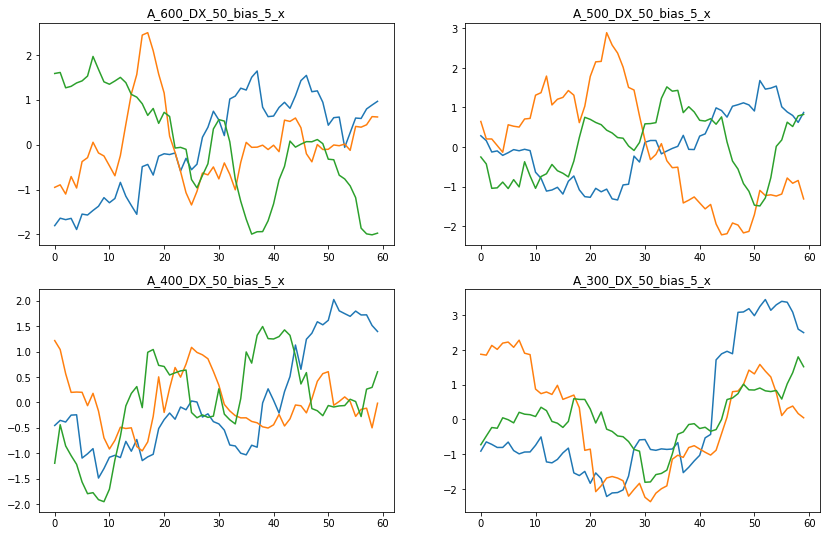

In [28]:
# DATA COMPARISON
fig1, ax1 = plt.subplots(len(data)//2,2,figsize=(14,9))
ax1 = ax1.flatten()
i=0
for k in data:
    ax1[i].plot(data[k][0])
    ax1[i].plot(data[k][1])
    ax1[i].plot(data[k][2])
    ax1[i].set_title(k)
    i += 1
plt.show()

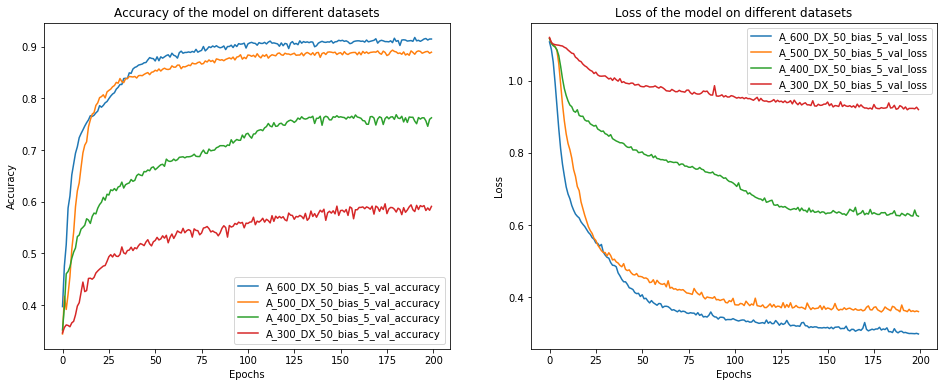

In [29]:
fig2, ax2 = plt.subplots(1,2,figsize=(16,6))
for key in keys:
    if 'accuracy' in key:
        ax2[0].plot(plots[key], label=key)
        ax2[0].set_xlabel('Epochs')
        ax2[0].set_ylabel('Accuracy')
        ax2[0].set_title('Accuracy of the model on different datasets')
        ax2[0].legend()
    if 'loss' in key:
        ax2[1].plot(plots[key], label=key)
        ax2[1].set_xlabel('Epochs')
        ax2[1].set_ylabel('Loss')
        ax2[1].set_title('Loss of the model on different datasets')
        ax2[1].legend()
plt.show()

As you can see, changing the amplitude of the perturbation, and so reducing the ratio signal-noise, the consequence on the model are visible: already with the modification 500 -> 400, the accuracy of the model has decreased, while the total loss turns out to be much bigger. Anyway, the behaviour of the model is so clear, in the sense that its efficiency decreases with the amplitude of the "pulse", while for A > 500, the results are quite similar, meaning that the model itself has an intrinsec limit.